In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [77]:
data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

In [78]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Input variables:
# bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [79]:
print("Number of rows",data.size)
print("Number of columns", len(data.columns))
print("Columns")
print(data.columns)

Number of rows 76857
Number of columns 17
Columns
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [80]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


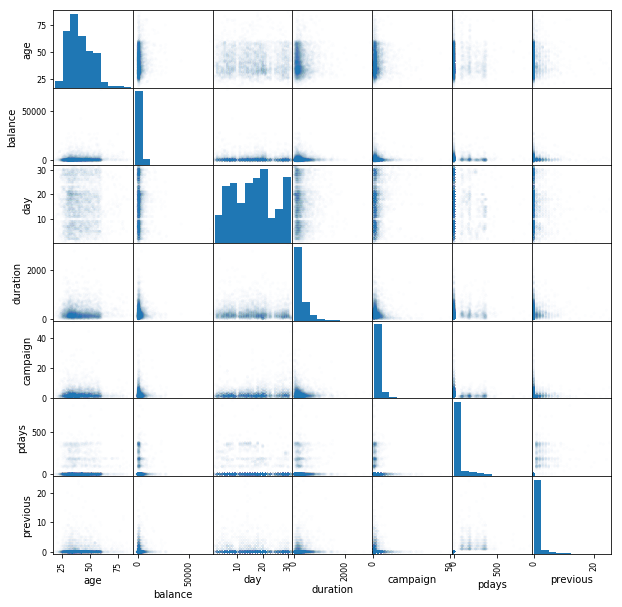

In [81]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

Вычислим попарную корреляцию столбцов

In [82]:
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


In [83]:
data.describe(include = ['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


Столбец poutcome практически полностью неизвестен. Возможно, имеет смысл исключить его из тренировочных данных.

### Удалим все строки, где есть пропущенные значения

Удалим стобцы, где присутствует мало значений или сами признаки, вероятно, не имеют большого смысла.

In [84]:
data = data.drop(['poutcome', 'day', 'month','duration'], axis=1)
data = data.dropna(axis = 0)

Разделим признаки на категориальные и числовые, для удобства последующей работы с ней.

In [85]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
numerical_columns   = ['age', 'balance', 'campaign', 'pdays', 'previous']                          
binary_columns      = ['default', 'housing', 'loan', 'y']                                          
nonbinary_columns   = ['job', 'marital', 'education', 'contact']                                   

In [86]:
#data_describe = data.describe(include = [object])
# [c for c in data.columns if data[c].dtype.name == 'object']
# [c for c in data.columns if data[c].dtype.name != 'object']
# [c for c in categorical_columns if data_describe[c]['unique'] == 2]
# [c for c in categorical_columns if data_describe[c]['unique'] > 2]

#print("Categorical columns", categorical_columns)
#print("Numberical columns", numerical_columns)
#print("Binary columns", binary_columns)
#print("Nonbinary columns", nonbinary_columns)

Переведем все бинарные признаки к одному виду.

In [87]:
for column in binary_columns:
    data.at[data[column] == 'no', column] = 0
    data.at[data[column] == 'yes', column] = 1

# Векторизируем небинарные признаки

Произведем векторизацию категориальных признаков. 
Среди присутствующих нет признаков, имеющих заведомо разную значимость. То есть все значения, внутри каждого признака, можно считать равнозначными. 

In [88]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

Многие методы чувствительны к масштабы данных. 
Нормализуем каждый вектор признаков, чтобы разница между значениями различных признаков была не столь велика.

In [89]:
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,age,balance,campaign,pdays,previous
count,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03
mean,-1.116976e-16,1.923122e-17,6.034397e-16,-1.955721e-16,-2.665910e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.096223e+00,-1.573497e+00,-5.767657e-01,-4.071733e-01,-3.203774e-01
25%,-7.724974e-01,-4.497743e-01,-5.767657e-01,-4.071733e-01,-3.203774e-01
50%,-2.051864e-01,-3.251746e-01,-2.552023e-01,-4.071733e-01,-3.203774e-01
75%,7.403318e-01,1.905285e-02,6.636113e-02,-4.071733e-01,-3.203774e-01
max,4.333301e+00,2.318064e+01,1.517984e+01,8.302277e+00,1.444141e+01


# Соединяем все в одну таблицу

In [90]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)
data.describe()

(4521, 31)


,age,balance,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,default,housing,loan,y
count,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,...,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,-1.116976e-16,1.923122e-17,6.034397e-16,-1.955721e-16,-2.665910e-16,0.105729,0.209246,0.037160,0.024773,0.214333,...,0.510064,0.298607,0.041363,0.640566,0.066578,0.292856,0.016810,0.566025,0.152842,0.115240
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.307524,0.406815,0.189174,0.155451,0.410404,...,0.499954,0.457697,0.199149,0.479888,0.249318,0.455123,0.128575,0.495676,0.359875,0.319347
min,-2.096223e+00,-1.573497e+00,-5.767657e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.724974e-01,-4.497743e-01,-5.767657e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.051864e-01,-3.251746e-01,-2.552023e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,7.403318e-01,1.905285e-02,6.636113e-02,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,4.333301e+00,2.318064e+01,1.517984e+01,8.302277e+00,1.444141e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Удалим часть тестовых данных, чтобы немного уравновесить количество элементов класса

In [91]:
reduce_size = True
size = min(len(data.loc[data['y'] == 0]), len(data.loc[data['y'] == 1]))
if reduce_size:
    size //= 2
data = pd.concat([data.loc[data['y'] == 0].sample(size), data.loc[data['y'] == 1].sample(size)])

# X и y

In [92]:
X = data.drop(('y'), axis = 1)
y = data['y']
feature_names = X.columns
N, d = X.shape

Разделим данные на тестовую и тренировочную выборки

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

364 156


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

# Function to prepare a whole dataset. Used for experiments with dataset size
#Gets row df and returns preprocessed features and targets
def prepare_dataset(data, max_size = None, align_class_size=False, print_size=False):
    #remove useless columns
    data = data.drop(['poutcome', 'day', 'month','duration'], axis=1)
    data = data.dropna(axis = 0)
    
    
    data_describe = data.describe(include = [object])
    categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
    numerical_columns   = ['age', 'balance', 'campaign', 'pdays', 'previous']
    binary_columns      = ['default', 'housing', 'loan', 'y']
    nonbinary_columns   = ['job', 'marital', 'education', 'contact']
    
    #binarization
    for column in binary_columns:
        data.at[data[column] == 'no', column] = 0
        data.at[data[column] == 'yes', column] = 1
    
    #one hot encoding 
    data_nonbinary = pd.get_dummies(data[nonbinary_columns])
    data_numerical = data[numerical_columns]
    
    #normalization
    data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
    
    data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
    
    negative_size = len(data.loc[data['y'] == 0])
    positive_size = len( data.loc[data['y'] == 1])
    
    if align_class_size:
        size = min(negative_size, positive_size)
        negative_size = size
        positive_size = size
        
    if max_size != None:
        negative_size = min(negative_size, max_size)
        positive_size = min(positive_size, max_size)
        
    data = pd.concat([data.loc[data['y'] == 0].sample(negative_size), data.loc[data['y'] == 1].sample(positive_size)])
    
    X = data.drop(('y'), axis = 1)
    y = data['y']
    
    if print_size:
        print(len(X))
        
    return X, y

# Подбор параметров

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X, y = prepare_dataset(data=pd.read_csv('data/bank.csv', sep = ';', engine = 'python'), align_class_size=True, print_size=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=5)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print("Train error", err_train)
print("Test error", err_test)

4521
0.11630847029077118 25
Train error 0.11441213653603034
Test error 0.11274871039056743


# kNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

X, y = prepare_dataset(data=pd.read_csv('data/bank.csv', sep = ';', engine = 'python'), align_class_size=True, print_size=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print("Train error", err_train)
print("Test error", err_test)
print("Confusion matrix", confusion_matrix(y_test, y_test_predict))

4521
Train error 0.11599241466498103
Test error 0.11495946941783346
Confusion matrix [[1201    3]
 [ 153    0]]


# Вывод

Подбор параметров показал, что наименьшая ошибка достигается при колчесвте соседей = 25.
Однако, стоит заметить, что отличие от результата, полученного с количеством соседей = 10, меньше 1%

# Подбор параметров

In [121]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC()
grid = GridSearchCV(svc, param_grid = {'C': Cs, 'gamma': gamma_array}, cv=5)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print(best_cv_err, best_C)

0.11504424778761058 100.0


# SVC

In [122]:
svc = SVC(gamma="scale")
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.11630847029077118 0.11274871039056743


In [123]:
svc = SVC(C=best_C, gamma=best_gamma).fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.11346396965865993 0.11348563006632277


# Neural networks

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

num_layers = 4

In [125]:
#data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

## Проведем предобработку данных, аналогично предыдущему модулю

## Разбиваем данные на тренировочную и тестовую выборки

In [126]:
from sklearn.model_selection import train_test_split

X = data.drop(('y'), axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

## Созданим нейронную сеть, для решения задачи классификации

In [127]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes = (num_layers,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [128]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [129]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.8505747126436781 0.5174418604651163


## Подбор гиперпараметров

In [130]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (num_layers,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

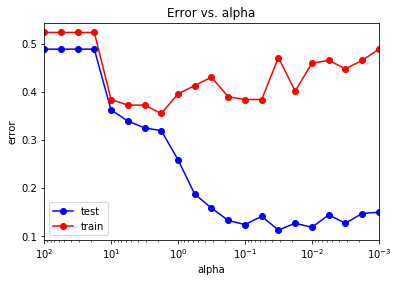

In [131]:

plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [132]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.11206896551724138 0.3546511627906977


In [133]:

alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.77827941]


In [134]:
alpha_opt = alpha_opt[0]

In [135]:
layers_num = [1, 2, 3, 4, 10, 100]
test_err = []
train_err = []
for num in layers_num:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

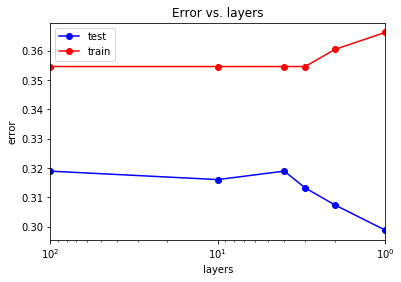

In [136]:
plt.semilogx(layers_num, train_err, 'b-o', label = 'test')
plt.semilogx(layers_num, test_err, 'r-o', label = 'train')
plt.xlim([np.max(layers_num), np.min(layers_num)])
plt.title('Error vs. layers')
plt.xlabel('layers')
plt.ylabel('error')
plt.legend()
pass

## Обучим классификатор с найденным оптимальным значением alpha и нейронов

In [137]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num_layers,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(mlp_model.score(X_train, y_train))
print(mlp_model.score(X_test, y_test))

0.6810344827586207
0.6453488372093024


In [138]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_pred, y_train))

[[125  58]
 [ 53 112]]


Сеть имеет свойство плохо определять значения класса, соответствующего y = 1. Возможно это связано с тем, что в тренировочной выборке недостаточно значение данного класса.

## Применим для классификации ансамбли деревьев

In [139]:
X, y = prepare_dataset(data=pd.read_csv('data/bank.csv', sep = ';', engine = 'python'), align_class_size=False, print_size=True)
X_test, y_test = prepare_dataset(data=pd.read_csv('data/bank-full.csv', sep = ';', engine = 'python'), print_size=True)


4521
45211


In [140]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

max_depth = [10, 20, 30, 40]

classifiers = {"Random forest" : 
               {"classifier" : ensemble.RandomForestClassifier,
               "parameters" : {"n_estimators" : range(1, 50), 
                               "max_depth" : max_depth}, 
                               "n_jobs" : -1},
              "Extreme Random Forest" :
               {"classifier" : ensemble.ExtraTreesClassifier,
               "parameters" : {"n_estimators" : range(1, 50), 
                               "max_depth" : max_depth},
                               "criterion" : ["gini", "entropy"],
                               "n_jobs" : -1},
              "Ada boost" :
               {"classifier" : ensemble.AdaBoostClassifier,
               "parameters" : {"n_estimators" : range(1, 50)}},
               "GBT" :
               {"classifier" : ensemble.GradientBoostingClassifier,
               "parameters" : {"n_estimators" : range(1, 50), "max_depth" : max_depth}}}

def visualize_oob_error(Classifier, estimators_count):
    oob_scores = []
    train_errors = []
    test_errors = []
    for count in estimators_count:
        clf = Classifier(n_estimators = count, oob_score=True)
        clf.fit(X, y)
        oob_scores.append(1 - clf.oob_score_)
        train_errors.append(1 - clf.score(X, y))
        test_errors.append(1 - clf.score(X_test, y_test))
    
    plt.title("OOB error ")
        
    plt.plot(estimators_count, oob_scores, label='oob')
    plt.plot(estimators_count, train_errors, label='train')
    plt.plot(estimators_count, test_errors, label='test')
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Mean error')
    plt.show()

def train_classifiers(Classifier, parameters):
    print(X.shape)
    train_errors = []
    test_errors = []
    #clf = GridSearchCV(Classifier(), parameters, cv=5, return_train_score=True)
    for count in parameters["n_estimators"]:
            clf = Classifier(n_estimators = count)
            scores = cross_validate(clf, X, y, cv=3, return_train_score=True)

            train_errors.append(1 - max(scores['train_score']))
            test_errors.append(1 - max(scores['test_score']))
        
    return train_errors, test_errors


def search_for_parameters(Classifier, parameters):
    cv_parameters = [1, 5, 10]
    for cv in cv_parameters:
        clf = GridSearchCV(Classifier(), parameters, cv=5, return_train_score=True)
        clf.fit(X, y)
        print("CV = ", cv, "Best parameters",  clf.best_params_)
        print("Classifier score", clf.score(X_test, y_test))
        print("Confusion matrix", confusion_matrix(y_test, clf.predict(X_test)))


def visualize_error_rate_for_estimators_number(estimators_number, train_error, test_error, plot_name = None, x_label = ""):
    #plt.figure(figsize=(12, 8))
    if (plot_name != None):
        plt.title(plot_name)
        
    plt.plot(estimators_number, train_error, label='train')
    plt.plot(estimators_number, test_error, label='test')
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel('Mean error')
    plt.show()

In [141]:
X, y = prepare_dataset(data=pd.read_csv('data/bank.csv', sep = ';', engine = 'python'), align_class_size=True, print_size=True)
X_test, y_test = prepare_dataset(data=pd.read_csv('data/bank-full.csv', sep = ';', engine = 'python'), align_class_size=True, print_size=True)
for name, parameters in classifiers.items():
    print(name)
    search_for_parameters(parameters["classifier"], parameters["parameters"])

1042
10578
Random forest
CV =  1 Best parameters {'max_depth': 10, 'n_estimators': 47}
Classifier score 0.6690300623936472
Confusion matrix [[3303 1986]
 [1515 3774]]
CV =  5 Best parameters {'max_depth': 10, 'n_estimators': 22}
Classifier score 0.6608999810928342
Confusion matrix [[3338 1951]
 [1636 3653]]
CV =  10 Best parameters {'max_depth': 10, 'n_estimators': 48}
Classifier score 0.6628852335034978
Confusion matrix [[3294 1995]
 [1571 3718]]
Extreme Random Forest
CV =  1 Best parameters {'max_depth': 10, 'n_estimators': 34}
Classifier score 0.6490830024579316
Confusion matrix [[2897 2392]
 [1320 3969]]
CV =  5 Best parameters {'max_depth': 10, 'n_estimators': 29}
Classifier score 0.6516354698430705
Confusion matrix [[3042 2247]
 [1438 3851]]
CV =  10 Best parameters {'max_depth': 10, 'n_estimators': 19}
Classifier score 0.6512573265267536
Confusion matrix [[3008 2281]
 [1408 3881]]
Ada boost
CV =  1 Best parameters {'n_estimators': 4}
Classifier score 0.6444507468330497
Confusion

4521
45211
(4521, 30)


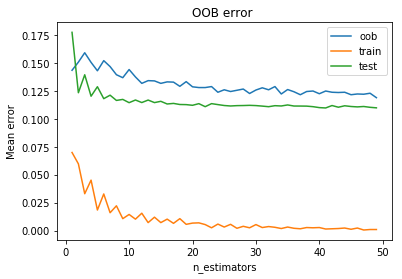

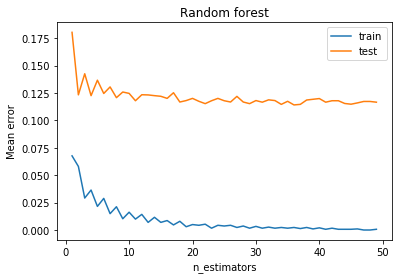

(4521, 30)


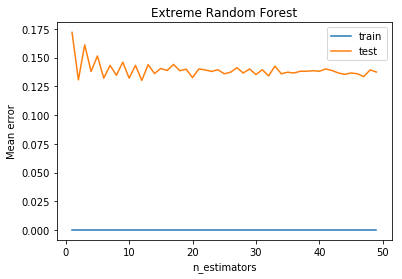

(4521, 30)


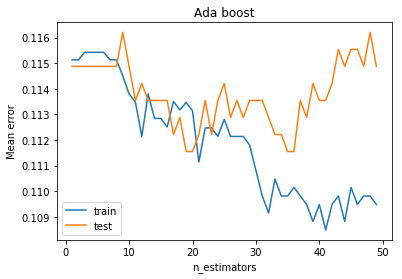

(4521, 30)


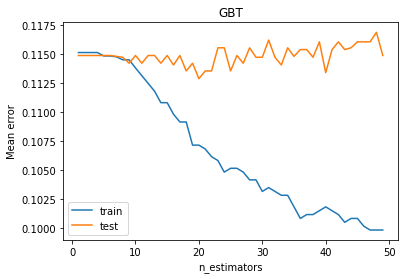

In [142]:
X, y = prepare_dataset(data=pd.read_csv('data/bank.csv', sep = ';', engine = 'python'), align_class_size=False, print_size=True)
X_test, y_test = prepare_dataset(data=pd.read_csv('data/bank-full.csv', sep = ';', engine = 'python'), print_size=True)

for name, parameters in classifiers.items():
    n_estimators = parameters["parameters"]["n_estimators"]
    train_errors, test_errors = train_classifiers(parameters["classifier"], parameters["parameters"])
    if name == "Random forest":
       visualize_oob_error(parameters["classifier"], n_estimators)
    visualize_error_rate_for_estimators_number(n_estimators, train_errors, test_errors, name, 'n_estimators')

Для ансамблей деревьев был проведен ряд экспериментов.   
Во-первых, был произведен перебор таких параметорв как максимальная глубина дерева и количество деревьв в ансамбле. Наилучшие результаты были получены при высоте дерва равным 10.  
Во-вторых на вход подавались различные датасеты. Наилучший результат был получен, если не выравнивать количество экземляров класса.   
Для Random Forest и Extreme Random Forest наблюдается явное переобучение.  

## Let's  try to reduce feature dimension.

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier

In [144]:
pipe = Pipeline([
    ('pca', PCA()),
    ('clf', MLPClassifier(hidden_layer_sizes = (4,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)),
])

parameters = {
    'pca__n_components': list(range(7,30)),
    #'clf__C': [1, 10, 100],
    }

X, y = prepare_dataset(data=pd.read_csv('data/bank-full.csv', sep = ';', engine = 'python'), align_class_size=False)

gs = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1)
gs.fit(X, y)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_l...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [145]:
print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.883
Best parameters set:
	pca__n_components: 25


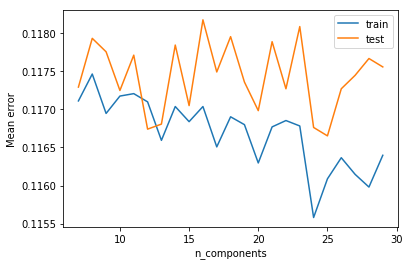

In [146]:
visualize_error_rate_for_estimators_number(list(range(7,30)),[1 - x for x in gs.cv_results_['mean_train_score']], [1 - x for x in gs.cv_results_['mean_test_score']], x_label='n_components')
